In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
# This Python 3 environ|ment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Tyndall_internship_2021/histogram_1330/eye_sim_2021_06_19'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [105]:
import numpy as np
import keras
import scipy.io
import tensorflow as tf
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from keras.optimizers import Adam
from keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.utils import to_categorical
import matplotlib.pyplot as pyplot
from PIL import Image
from zipfile import ZipFile
#import pydicom
import os
import scipy.ndimage
from PIL import Image
import sys
import csv


# ***Image-read***

In [106]:
train_dir=os.path.join("/content/drive/MyDrive/Tyndall_internship_2021/histogram_1330/" )

In [107]:
#Useful function
def createFileList(myDir, format='.mat'):
  fileList = []
  print(myDir)
  for root, dirs, files in os.walk(myDir, topdown=False):
    for name in files:
      if name.endswith(format):
        fullName = os.path.join(root, name)
        fileList.append(fullName)
  return fileList

# load the original image
myFileList = createFileList('/content/drive/MyDrive/Tyndall_internship_2021/histogram_1330/eye_sim_2021_06_19')
train_arr = []
for file in myFileList:
    #print(file)
    mat_contents = scipy.io.loadmat(file)
    #print(sorted(mat_contents.keys()))
    train_arr.append(mat_contents['eyeimage_matrix'])

    #img_file = Image.open(file)
    #img_file= Image.open(img_file)


/content/drive/MyDrive/Tyndall_internship_2021/histogram_1330/eye_sim_2021_06_19


In [108]:
train_arr= np.reshape(train_arr,(1330, 401, 384,1))
np.shape(train_arr)

(1330, 401, 384, 1)

In [109]:
#train_data_gen= ImageDataGenerator(rescale=1./255,validation_split=0.1)
#train_generator = train_data_gen.flow(
#    x=train_arr,
 #   batch_size=10,
  #  shuffle=True,
   # subset='training'
#)
#val_generator = train_data_gen.flow(
#    x=train_arr,
#    batch_size=10,
#    shuffle=True,
#    subset='validation'
#)

# ***ENCODER***

In [110]:
from tensorflow.keras import layers
#encoder
filters=(32, 64)
chanDim = -1
latentDim=16
# define the input to the encoder
inputs = layers.Input(shape=(401,384,1))
x = inputs
# loop over the number of filters
for f in filters:
	# apply a CONV => RELU => BN operation
	x = layers.Conv2D(f, (3, 3), strides=2, padding="same")(x)
	x = layers.LeakyReLU(alpha=0.2)(x)
	x = layers.BatchNormalization(axis=chanDim)(x)
print(np.shape(x))
# flatten the network and then construct our latent vector
volumeSize = K.int_shape(x)
print(volumeSize[1], volumeSize[2], volumeSize[3])
x =layers.Flatten()(x)
x= layers.LeakyReLU(alpha=0.2)(x)
latent = layers.Dense(latentDim)(x)
# build the encoder model
encoder = Model(inputs, latent, name="encoder")

(None, 101, 96, 64)
101 96 64


In [111]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 9,947,920
Trainable params: 9,947,728
Non-trainable params: 192
_________________________________________________________________


# ***DECODER***

In [112]:
#decoder
# output of the encoder as its inputs
latentInputs = layers.Input(shape=(latentDim,))
x = layers.Dense(np.prod(volumeSize[1:]))(latentInputs)
x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)
print(np.shape(x))
for f in filters[::-1]:
	# apply a CONV_TRANSPOSE => RELU => BN operation
	x = layers.Conv2DTranspose(f, (3, 3), strides=2,padding="same")(x)
	x = layers.LeakyReLU(alpha=0.2)(x)
	x = layers.BatchNormalization(axis=chanDim)(x)
x= layers.Cropping2D(cropping=((3, 0), (0, 0)), data_format=None)(x)
print(np.shape(x))

(None, 101, 96, 64)
(None, 401, 384, 32)


In [113]:
# apply a single CONV_TRANSPOSE layer used to recover the
# original depth of the image
x = layers.Conv2DTranspose(1, (3, 3), padding="same")(x)
print(np.shape(x))
outputs = Activation("sigmoid")(x)
# build the decoder model
decoder = Model(latentInputs, outputs, name="decoder")
# our autoencoder is the encoder + decoder
autoencoder = Model(inputs, decoder(encoder(inputs)),name="autoencoder")
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)    

print(np.shape(x))

(None, 401, 384, 1)
(None, 401, 384, 1)


In [145]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 9,947,920
Trainable params: 9,947,728
Non-trainable params: 192
_________________________________________________________________


In [114]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 10,605,313
Trainable params: 10,605,121
Non-trainable params: 192
_________________________________________________________________


In [115]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 20,553,233
Trainable params: 20,552,849
Non-trainable params: 384
_________________________________________________________________


In [116]:
autoencoder.compile(loss='mean_squared_error', optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07))


In [117]:
#x= train_x(what we input), y= train_x(what is desired output) same for validation 
trained_model = autoencoder.fit(train_arr,train_arr, batch_size=20, epochs=10, verbose=1)

Epoch 1/10
67/67 [==============================] - 506s 8s/step - loss: 0.0848
Epoch 2/10
67/67 [==============================] - 511s 8s/step - loss: 0.0288
Epoch 3/10
67/67 [==============================] - 515s 8s/step - loss: 0.0236
Epoch 4/10
67/67 [==============================] - 515s 8s/step - loss: 0.0181
Epoch 5/10
67/67 [==============================] - 511s 8s/step - loss: 0.0091
Epoch 6/10
67/67 [==============================] - 512s 8s/step - loss: 0.0060
Epoch 7/10
67/67 [==============================] - 519s 8s/step - loss: 0.0045
Epoch 8/10
67/67 [==============================] - 512s 8s/step - loss: 0.0034
Epoch 9/10
67/67 [==============================] - 511s 8s/step - loss: 0.0024
Epoch 10/10
67/67 [==============================] - 511s 8s/step - loss: 0.0019


#  ***RESULTS***

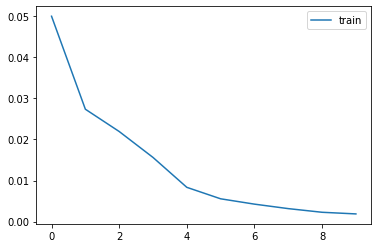

In [119]:
pyplot.plot(trained_model.history['loss'], label='train')
#pyplot.plot(trained_model.history['val_loss'], label='val')
pyplot.legend()
pyplot.savefig('plot_histogram_auto.png')
pyplot.show()

In [157]:
file_dir='/content/drive/MyDrive/Tyndall_internship_2021/histogram_1330/eye_sim_2021_06_19/m2_fibre10_pow_14_filt15.mat'
mat_contents_test = scipy.io.loadmat(file_dir)
test_data_1=mat_contents_test['eyeimage_matrix']
print(np.shape(test_data_1))
test_data= np.reshape(test_data_1,(1, 401, 384,1))
decoded_output_1 = autoencoder.predict(test_data)*255
decoded_output=np.reshape(decoded_output_1,(401, 384))
#print(decoded_output[99,210,50,:])

(401, 384)


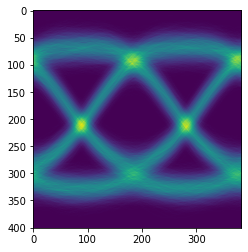

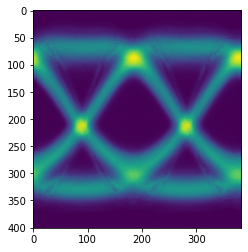

In [158]:
import cv2
pyplot.imshow(test_data_1[:,:])
pyplot.savefig('test_data_fibre10_pow_11_filt25.png')
pyplot.show()
pyplot.imshow(decoded_output[:,:])
pyplot.savefig('test_pred_fibre10_pow_11_filt25.png')
pyplot.show()



In [138]:
encoder.save('encoder_histogram_16.h5')

KeyError: ignored